In [1]:
# Import necessary libraries
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, ConfusionMatrixDisplay
import joblib
import pandas as pd
import matplotlib.pyplot as plt



In [2]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shlok\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shlok\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Preprocessing function
def preprocess(text):
    stop_words = set(stopwords.words('english'))
    tokens = nltk.word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]  # Remove punctuation
    tokens = [word for word in tokens if word not in stop_words]  # Remove stop words
    return ' '.join(tokens)


In [4]:

# Summarization function with dynamic levels
def summarize(text, model, tfidf, level='Medium'):
    sentences = nltk.sent_tokenize(text)
    cleaned_sentences = [preprocess(sentence) for sentence in sentences]
    
    # Transform sentences into TF-IDF vectors
    sentence_vectors = tfidf.transform(cleaned_sentences).toarray()
    
    # Predict importance of each sentence
    sentence_scores = model.predict_proba(sentence_vectors)[:, 1]
    
    # Rank sentences by importance
    ranked_sentences = sorted(((score, sent) for score, sent in zip(sentence_scores, sentences)), reverse=True)
    
    # Determine the number of sentences to include based on the chosen summarization level
    if level == 'Low':
        num_sentences = max(1, int(0.1 * len(sentences)))  # 10% of the sentences
    elif level == 'Medium':
        num_sentences = max(1, int(0.3 * len(sentences)))  # 30% of the sentences
    elif level == 'High':
        num_sentences = max(1, int(0.5 * len(sentences)))  # 50% of the sentences
    
    # Generate summary using the top-ranked sentences
    summary = " ".join([sent for score, sent in ranked_sentences[:num_sentences]])
    
    return summary



In [5]:
# Training the model
def train_model():
    # Sample data for training (can be extended with a larger dataset)
    data = [
        ("The quick brown fox jumps over the lazy dog.", 0),
        ("This is a significant sentence worth noting.", 1),
        ("Completely irrelevant information for testing.", 0),
        ("An essential detail in the context of our study.", 1),
        ("This is another trivial statement.", 0),
        ("Final important message for our dataset.", 1),
        ("Random noise added for distraction.", 0),
        ("Key data point that needs to be highlighted.", 1),
        ("Unnecessary fluff without much value.", 0),
        ("A critical conclusion to support our analysis.", 1),
        ("A random sentence with no real meaning.", 0),
        ("This piece of data is essential for decision making.", 1),
        ("Filler text that doesn't matter.", 0),
        ("This sentence contains valuable insights.", 1),
        ("A generic sentence with no real importance.", 0),
        ("This piece of information is quite crucial.", 1),
        ("Noise in the dataset that can be ignored.", 0),
        ("Important observation related to the research.", 1),
        ("Just some more filler data.", 0),
        ("Final crucial sentence for this section.", 1),
        ("This doesn't add much value.", 0),
        ("A critical finding from the experiment.", 1),
        ("A completely irrelevant piece of information.", 0),
        ("This sentence is very informative.", 1),
        ("Just a random sentence.", 0),
        ("An insightful conclusion from the report.", 1),
        ("Another filler sentence that can be ignored.", 0),
        ("This point is extremely important.", 1),
        ("A completely unnecessary distraction.", 0),
        ("A vital observation about the trends.", 1),
        ("Random text to pad out the dataset.", 0),
        ("This is a key takeaway from the study.", 1),
        ("This doesn't help with the analysis.", 0),
        ("An essential discovery in the research.", 1),
        ("A sentence that holds no significance.", 0),
        ("Critical insight that should be noted.", 1),
        ("Just another random statement.", 0),
        ("A crucial finding that backs our theory.", 1),
        ("Unnecessary information for testing.", 0),
        ("This sentence highlights an important detail.", 1),
        ("More random sentences with no value.", 0),
        ("A key conclusion drawn from the dataset.", 1),
        ("Filler text not needed for conclusions.", 0),
        ("This is an important insight.", 1),
        ("Random sentence without meaning.", 0),
        ("A vital piece of information.", 1),
        ("Another random sentence.", 0),
        ("An essential takeaway from the results.", 1),
        ("Unimportant detail that can be skipped.", 0),
        ("This is an important finding.", 1),
        ("Just filler text for the dataset.", 0),
        ("A key observation in the analysis.", 1),
        ("This doesn't contribute to the results.", 0),
        ("An important note for future reference.", 1),
        ("Completely irrelevant sentence.", 0),
        ("A significant point to remember.", 1),
        ("Random sentence for no reason.", 0),
        ("A crucial detail in the conclusion.", 1),
        ("This is just noise.", 0),
        ("An essential observation from the data.", 1),
        ("More irrelevant content.", 0),
        ("A final important finding.", 1),
        ("Filler text without purpose.", 0),
        ("This sentence is quite important.", 1),
        ("A sentence that doesn't matter.", 0),
        ("An important conclusion drawn from data.", 1),
        ("Random text for testing purposes.", 0),
        ("A vital point highlighted in the report.", 1),
        ("More random filler sentences.", 0),
        ("This is a crucial observation.", 1),
        ("This sentence adds no value.", 0),
        ("An insightful comment based on research.", 1),
        ("Random data added for no reason.", 0),
        ("A significant result from the analysis.", 1),
        ("Unimportant sentence for padding.", 0),
        ("An important observation related to trends.", 1),
        ("A sentence without any impact.", 0),
        ("This is an insightful conclusion.", 1),
        ("Just another random sentence.", 0),
        ("A key takeaway for further investigation.", 1),
        ("Filler text with no importance.", 0),
        ("This sentence is crucial to understanding.", 1),
        ("Random words with no meaning.", 0),
        ("A critical observation in the dataset.", 1),
        ("Just another random phrase.", 0),
        ("This is an important discovery.", 1),
        ("More filler data.", 0),
        ("A vital insight into the research.", 1),
        ("Another irrelevant sentence.", 0),
        ("A key observation in the findings.", 1),
        ("Random filler text.", 0),
        ("This is a crucial piece of information.", 1),
        ("Unimportant sentence without context.", 0),
        ("This is an important conclusion.", 1),
        ("Just random filler text.", 0),
        ("A significant point to note from the analysis.", 1)
    
    ]

    
    df = pd.DataFrame(data, columns=['sentence', 'label'])
    df['cleaned'] = df['sentence'].apply(preprocess)

    # Vectorize sentences using TF-IDF
    tfidf = TfidfVectorizer(max_features=100)
    X = tfidf.fit_transform(df['cleaned']).toarray()
    y = df['label']

    # Train a Logistic Regression model
    model = LogisticRegression()
    model.fit(X, y)

    # Save the model and TF-IDF vectorizer
    joblib.dump(model, "summarization_model.pkl")
    joblib.dump(tfidf, "tfidf_vectorizer.pkl")

    return model, tfidf



In [6]:
# Train and save the model
model, tfidf = train_model()
print("Model trained and saved.")



Model trained and saved.


In [7]:
# Function to evaluate the model
def evaluate_model(model, tfidf):
    # Sample data for evaluation (can be extended with a larger dataset)
    data = [
        ("The quick brown fox jumps over the lazy dog.", 0),
        ("This is a significant sentence worth noting.", 1),
        ("Completely irrelevant information for testing.", 0),
        ("An essential detail in the context of our study.", 1),
        ("This is another trivial statement.", 0),
        ("Final important message for our dataset.", 1),
        ("Random noise added for distraction.", 0),
        ("Key data point that needs to be highlighted.", 1),
        ("Unnecessary fluff without much value.", 0),
        ("A critical conclusion to support our analysis.", 1),
        ("A random sentence with no real meaning.", 0),
        ("This piece of data is essential for decision making.", 1),
        ("Filler text that doesn't matter.", 0),
        ("This sentence contains valuable insights.", 1),
        ("A generic sentence with no real importance.", 0),
        ("This piece of information is quite crucial.", 1),
        ("Noise in the dataset that can be ignored.", 0),
        ("Important observation related to the research.", 1),
        ("Just some more filler data.", 0),
        ("Final crucial sentence for this section.", 1),
        ("This doesn't add much value.", 0),
        ("A critical finding from the experiment.", 1),
        ("A completely irrelevant piece of information.", 0),
        ("This sentence is very informative.", 1),
        ("Just a random sentence.", 0),
        ("An insightful conclusion from the report.", 1),
        ("Another filler sentence that can be ignored.", 0),
        ("This point is extremely important.", 1),
        ("A completely unnecessary distraction.", 0),
        ("A vital observation about the trends.", 1),
        ("Random text to pad out the dataset.", 0),
        ("This is a key takeaway from the study.", 1),
        ("This doesn't help with the analysis.", 0),
        ("An essential discovery in the research.", 1),
        ("A sentence that holds no significance.", 0),
        ("Critical insight that should be noted.", 1),
        ("Just another random statement.", 0),
        ("A crucial finding that backs our theory.", 1),
        ("Unnecessary information for testing.", 0),
        ("This sentence highlights an important detail.", 1),
        ("More random sentences with no value.", 0),
        ("A key conclusion drawn from the dataset.", 1),
        ("Filler text not needed for conclusions.", 0),
        ("This is an important insight.", 1),
        ("Random sentence without meaning.", 0),
        ("A vital piece of information.", 1),
        ("Another random sentence.", 0),
        ("An essential takeaway from the results.", 1),
        ("Unimportant detail that can be skipped.", 0),
        ("This is an important finding.", 1),
        ("Just filler text for the dataset.", 0),
        ("A key observation in the analysis.", 1),
        ("This doesn't contribute to the results.", 0),
        ("An important note for future reference.", 1),
        ("Completely irrelevant sentence.", 0),
        ("A significant point to remember.", 1),
        ("Random sentence for no reason.", 0),
        ("A crucial detail in the conclusion.", 1),
        ("This is just noise.", 0),
        ("An essential observation from the data.", 1),
        ("More irrelevant content.", 0),
        ("A final important finding.", 1),
        ("Filler text without purpose.", 0),
        ("This sentence is quite important.", 1),
        ("A sentence that doesn't matter.", 0),
        ("An important conclusion drawn from data.", 1),
        ("Random text for testing purposes.", 0),
        ("A vital point highlighted in the report.", 1),
        ("More random filler sentences.", 0),
        ("This is a crucial observation.", 1),
        ("This sentence adds no value.", 0),
        ("An insightful comment based on research.", 1),
        ("Random data added for no reason.", 0),
        ("A significant result from the analysis.", 1),
        ("Unimportant sentence for padding.", 0),
        ("An important observation related to trends.", 1),
        ("A sentence without any impact.", 0),
        ("This is an insightful conclusion.", 1),
        ("Just another random sentence.", 0),
        ("A key takeaway for further investigation.", 1),
        ("Filler text with no importance.", 0),
        ("This sentence is crucial to understanding.", 1),
        ("Random words with no meaning.", 0),
        ("A critical observation in the dataset.", 1),
        ("Just another random phrase.", 0),
        ("This is an important discovery.", 1),
        ("More filler data.", 0),
        ("A vital insight into the research.", 1),
        ("Another irrelevant sentence.", 0),
        ("A key observation in the findings.", 1),
        ("Random filler text.", 0),
        ("This is a crucial piece of information.", 1),
        ("Unimportant sentence without context.", 0),
        ("This is an important conclusion.", 1),
        ("Just random filler text.", 0),
        ("A significant point to note from the analysis.", 1)
    
    ]
    
    df = pd.DataFrame(data, columns=['sentence', 'label'])
    df['cleaned'] = df['sentence'].apply(preprocess)

    X = tfidf.transform(df['cleaned']).toarray()
    y = df['label']
    y_pred = model.predict(X)

    # Calculate metrics
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    accuracy = accuracy_score(y, y_pred)
    conf_matrix = confusion_matrix(y, y_pred)

    # Print metrics
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot()
    plt.title("Confusion Matrix")
    plt.show()



Precision: 1.0000
Recall: 0.9792
F1 Score: 0.9895
Accuracy: 0.9896


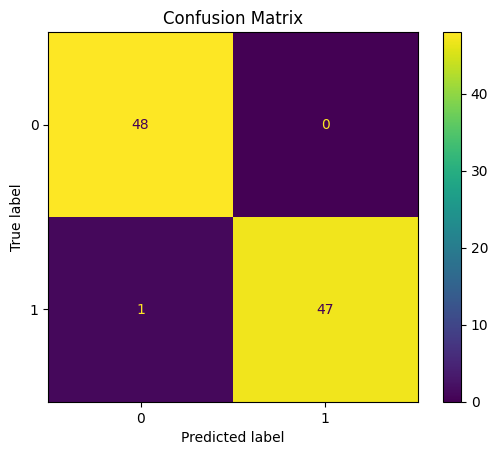

In [8]:
# Evaluate the model
evaluate_model(model, tfidf)



In [9]:
# Test the summarization
test_text = """
He was born as the second son to Kublai Khan and first to Chabi Khatun. The Chinese Zen Buddhist monk Haiyun gave him the name Zhenjin ("True Gold") when he was born in 1243.[3] He was created Prince of Yan (燕王), became the head of the Central Secretariat (Zhongshu Sheng) by his father in 1262,[3] and was designated as the Crown Prince (皇太子) of the Yuan dynasty by Kublai Khan in 1273.[4]

He was known as a strong supporter of Confucianism, having been tutored by Han scholars such as Yao Shu (1203–1280), Dou Mo (1196–1280), Liu Bingzhong (1216–1274) and Wang Xun. Among others, he was noted to have studied Classic of Poetry and Classic of Filial Piety.[5] After the death of Zhenjin's rival Ahmad Fanakati (according to Rashid al-Din, as a result of a plot by Zhenjin),[6] a Confucian-trained official in the South even proposed Kublai abdicate in favor of Zhenjin in 1285, as a result Kublai was furious. He was also known to be a friend of Drogön Chögyal Phagpa, who wrote the famous treatise "Explanation of the knowable" for Zhenjin.[7]

According to the History of Yuan, he died of alcoholism on 5 January 1286, eight years before his father Kublai Khan. However, it may not have been as simple as merely drinking too much. It is also stated that shortly before his death, some ministers of the court wanted to propose that Kublai Khan abdicate his throne to Prince Zhenjin on account of old age and because Zhenjin was highly respected throughout the empire. However, Zhenjin tried to prevent this from happening. Unfortunately, Kublai Khan found out anyway and was furious, which terrified Zhenjin and may have led him to overdrink.[8][3] Distressed by his death, Kublai Khan made Zhenjin's son Temür the new Crown Prince. He was posthumously renamed as Taizi Mingxiao by Kublai on 25 February 1293. Temür gave him posthumous name Emperor Wenhui Mingxiao (文惠明孝皇帝) and temple name Yuzong (Chinese: 裕宗; lit. 'Affluent Ancestor') on 3 June 1294.
"""



In [10]:
summary = summarize(test_text, model, tfidf, level='Medium')
print("Original Text:")
print(test_text)
print("\nSummarized Text:")
print(summary)

Original Text:

He was born as the second son to Kublai Khan and first to Chabi Khatun. The Chinese Zen Buddhist monk Haiyun gave him the name Zhenjin ("True Gold") when he was born in 1243.[3] He was created Prince of Yan (燕王), became the head of the Central Secretariat (Zhongshu Sheng) by his father in 1262,[3] and was designated as the Crown Prince (皇太子) of the Yuan dynasty by Kublai Khan in 1273.[4]

He was known as a strong supporter of Confucianism, having been tutored by Han scholars such as Yao Shu (1203–1280), Dou Mo (1196–1280), Liu Bingzhong (1216–1274) and Wang Xun. Among others, he was noted to have studied Classic of Poetry and Classic of Filial Piety.[5] After the death of Zhenjin's rival Ahmad Fanakati (according to Rashid al-Din, as a result of a plot by Zhenjin),[6] a Confucian-trained official in the South even proposed Kublai abdicate in favor of Zhenjin in 1285, as a result Kublai was furious. He was also known to be a friend of Drogön Chögyal Phagpa, who wrote the